In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.offline as opy
opy.init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline()

import tensorflow as tf

In [2]:
class Sampling(tf.keras.layers.Layer):
    '''
        Uses z_mean, z_log_var to sample z, the vector 
        encoding input.
    '''
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    
class Encoder(tf.keras.layers.Layer):
    '''
        Maps input to a z_mean, z_log_var, z.
    '''
    def __init__(
        self,
        latent_dim=32,
        intermediate_dim=64,
        name='encoder',
        **kwargs
    ):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = tf.keras.layers.Dense(
            intermediate_dim,
            activation='relu'
        )
        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_log_var = tf.keras.layers.Dense(latent_dim)
        self.sampling = Sampling()
        
    def call(self, inputs):
        x = self.dense_proj(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z
    

class Decoder(tf.keras.layers.Layer):
    '''
        Converts z, the encoded input vector, back to input. 
    '''
    def __init__(
        self,
        original_dim,
        intermediate_dim=64,
        output_activation='sigmoid',
        name='decoder',
        **kwargs
    ):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = tf.keras.layers.Dense(
            intermediate_dim,
            activation='relu'
        )
        self.dense_output = tf.keras.layers.Dense(
            original_dim, 
            activation=output_activation
        )

    def call(self, inputs):
        x = self.dense_proj(inputs)
        return self.dense_output(x)


class VAE(tf.keras.models.Model):
    '''
        Combines Encoder and Decoder.
    '''
    def __init__(
        self,
        original_dim,
        intermediate_dim=64,
        latent_dim=32,
        name='vae',
        **kwargs
    ):
        super(VAE, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder(
            latent_dim=latent_dim,
            intermediate_dim=intermediate_dim
        )
        self.decoder = Decoder(
            intermediate_dim=intermediate_dim,
            original_dim=original_dim
        )
        
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(kl_loss)
        return reconstructed

In [3]:
(x_training, _), _ = tf.keras.datasets.mnist.load_data()
x_training = x_training.reshape(60000, 784).astype('float32') / 255

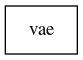

In [4]:
vae = VAE(784, 64, 32)
tf.keras.utils.plot_model(vae)

In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
history = vae.fit(x_training, x_training, epochs=3, batch_size=64)

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 2s 35us/sample - loss: 0.0747
Epoch 2/3
60000/60000 [==============================] - 2s 27us/sample - loss: 0.0676
Epoch 3/3
60000/60000 [==============================] - 2s 27us/sample - loss: 0.0676


In [6]:
results = pd.DataFrame(history.history)
results.iplot()